🌍 WELCOME TO THE CLIMATE FORECASTING SYSTEM
This system predicts Rainfall, Vegetation Health, and Temperature
for any available country or region for the next 5 years using SARIMAX!
It also provides a crop recommendation (Rice, Cassava, Maize)!
✅ Data loaded successfully. Total records: 17174

⚡ Running quick model evaluation...

📈 MODEL EVALUATION
Using sample of 500 records for evaluation
Accuracy: 0.048
Precision (Weighted): 0.006
Recall (Weighted): 0.048
F1-Score (Weighted): 0.011


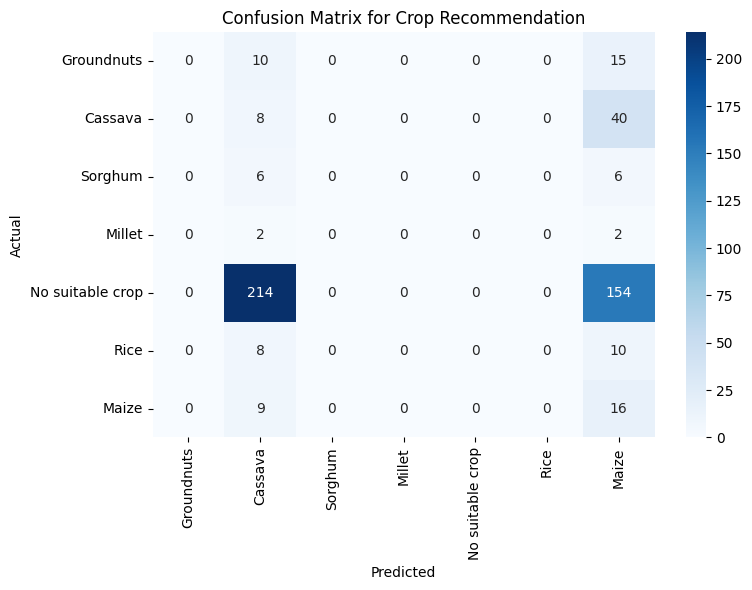

🌍 AVAILABLE COUNTRIES:
MWI: Malawi

📍 AVAILABLE REGIONS (showing first 15):
MWI.1.1_1: Northern Region - Chitipa
MWI.1.2_1: Northern Region - Karonga
MWI.1.3_1: Northern Region - Rumphi
MWI.2.1_1: Central Region - Kasungu
MWI.2.2_1: Central Region - Nkhotakota
MWI.2.3_1: Central Region - Ntchisi
MWI.2.4_1: Central Region - Dowa
MWI.2.5_1: Central Region - Salima
MWI.2.6_1: Central Region - Lilongwe
MWI.2.7_1: Central Region - Mchinji
MWI.2.8_1: Region MWI.2.8_1
MWI.2.9_1: Region MWI.2.9_1
MWI.3.1_1: Southern Region - Mangochi
MWI.3.2_1: Southern Region - Machinga
MWI.3.3_1: Southern Region - Zomba
... and 223 more regions

💡 Tip: Type 'Malawi' for country-level forecast or a GID code for regional analysis

✅ Prepared country-level data for Malawi
   Time range: 2022-01-01 00:00:00 to 2025-02-18 00:00:00
   Total records: 73

🔮 Forecasting for Malawi (5 years) using SARIMAX...


/Users/stephen/miniconda3/envs/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/stephen/miniconda3/envs/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/stephen/miniconda3/envs/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/stephen/miniconda3/envs/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

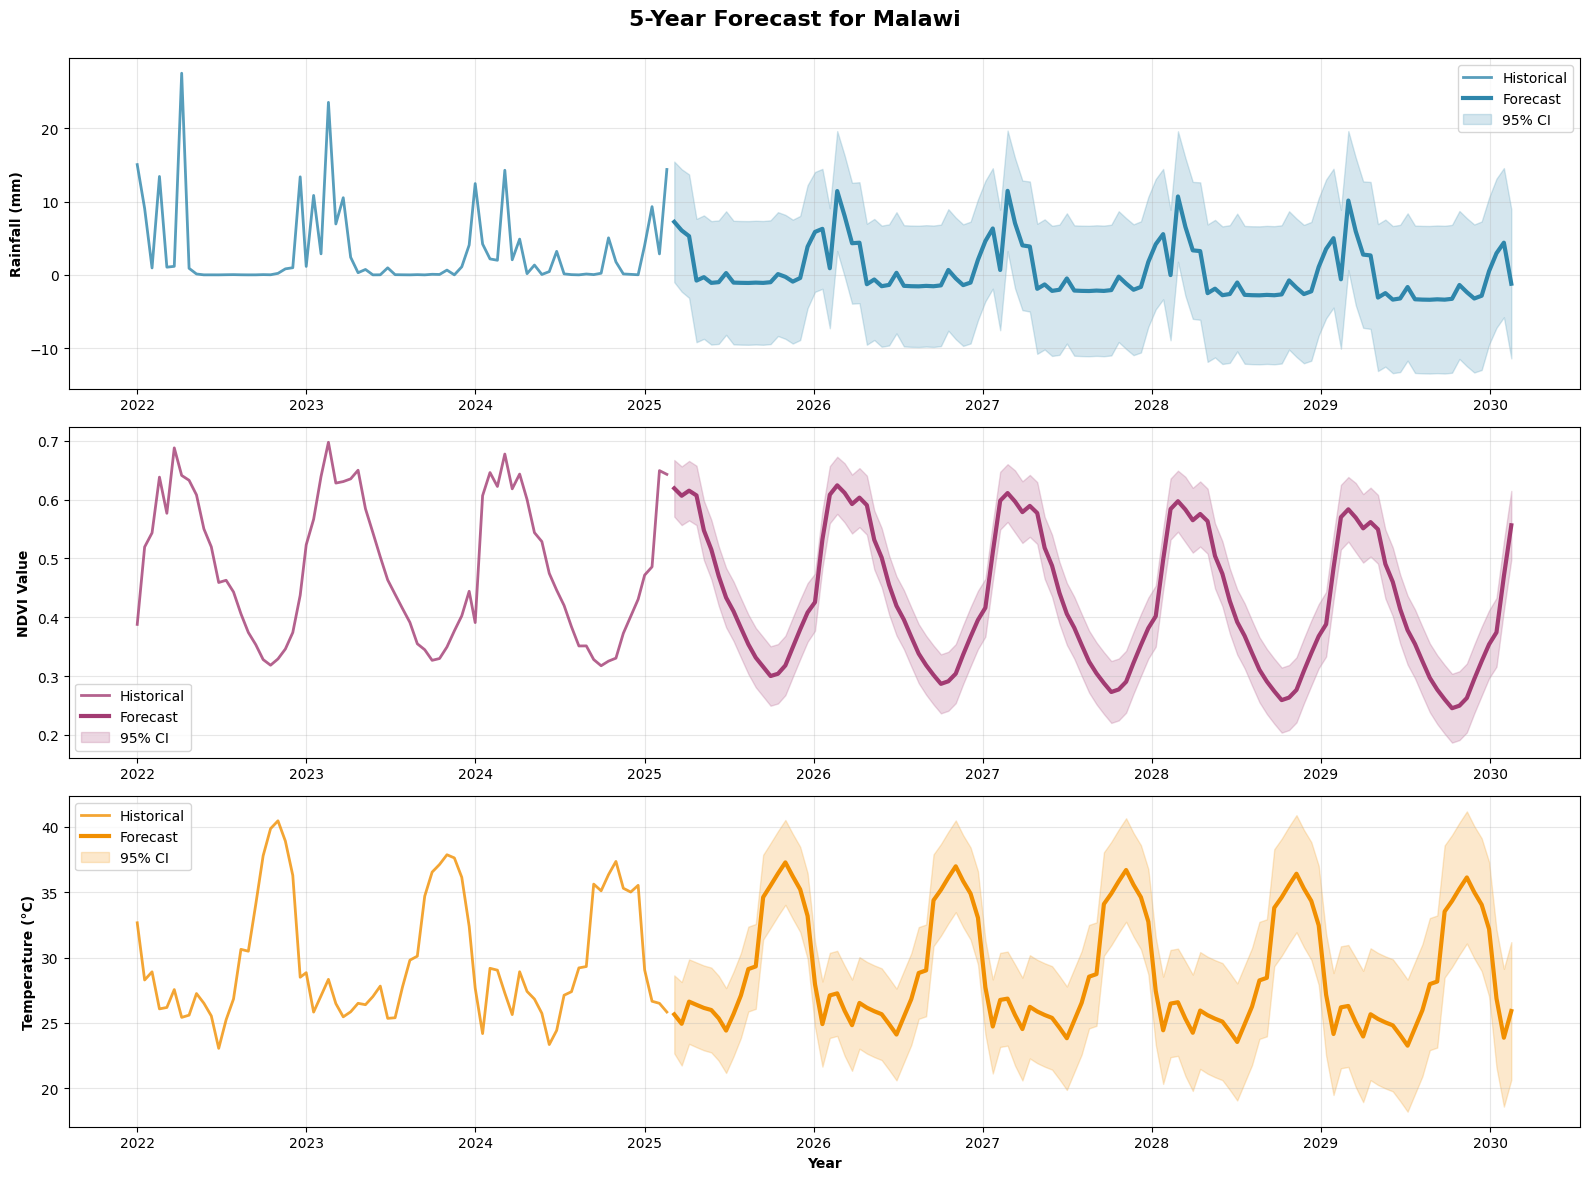


📊 FORECAST SUMMARY: Malawi

📅 Forecast Period: 2025-03-06 to 2030-02-16

🌧  Rainfall Forecast:
   Average: 0.4 mm
   Range: -3.4 - 11.5 mm

🌿 Vegetation Health (NDVI):
   Average: 0.426
   Range: 0.245 - 0.624

🌡  Temperature Forecast:
   Average: 28.7°C
   Range: 23.3 - 37.3°C

🌾 TOP 3 CROP RECOMMENDATIONS FOR Malawi
1. 🌾 Recommended Crop: Cassava
   🧠 Reason: Warmer conditions, even with moderate NDVI, favor drought-tolerant Cassava.
2. 🌾 Recommended Crop: Maize
   🧠 Reason: Moderate/lower temperature with moderate/low NDVI suits Maize.

📊 PREDICTION ACCURACY
Overall Accuracy of Crop Recommendations: 0.048

💾 Forecast saved to: forecast_malawi.csv

Thank you for using the Climate Forecasting System! 👋


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
warnings.filterwarnings('ignore')

# Add for new models
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# Global variable to store accuracy
overall_accuracy = None

# --- Crop Recommendation Logic ---
def recommend_crop(avg_temp, avg_ndvi):
    """
    Recommends up to three crops (Rice, Cassava, Maize) based on average forecasted
    Temperature (LST) and NDVI, ranked by suitability.
    """
    high_temp_threshold = 29.0
    moderate_temp_upper = 31.0
    moderate_ndvi_threshold = 0.55
    recommendations = []

    # Evaluate conditions and build ranked list
    if avg_temp > high_temp_threshold:
        if avg_ndvi > moderate_ndvi_threshold:
            recommendations.append(("Cassava", "High temperature and high NDVI are ideal for Cassava."))
        recommendations.append(("Cassava", "High temperature; Cassava is the most drought-tolerant option."))
    else:
        if avg_ndvi > moderate_ndvi_threshold:
            if high_temp_threshold < avg_temp <= moderate_temp_upper:
                recommendations.append(("Rice", "Moderate temperature with high NDVI suggests good water availability, suitable for Rice."))
            if avg_temp <= high_temp_threshold:
                recommendations.append(("Maize", "Moderate/lower temperature with high NDVI, suitable for Maize."))
            recommendations.append(("Rice", "Conditions support high vegetation health, suitable for Rice."))
        else:
            if avg_temp > high_temp_threshold - 1.5:
                recommendations.append(("Cassava", "Warmer conditions, even with moderate NDVI, favor drought-tolerant Cassava."))
            recommendations.append(("Maize", "Moderate/lower temperature with moderate/low NDVI suits Maize."))

    # Ensure at least three recommendations, filling with defaults if needed
    while len(recommendations) < 3:
        if avg_temp > high_temp_threshold and ("Cassava", "Defaulting to Cassava for high temperature.") not in recommendations:
            recommendations.append(("Cassava", "Defaulting to Cassava for high temperature."))
        elif avg_ndvi > moderate_ndvi_threshold and ("Rice", "Defaulting to Rice for high NDVI with non-extreme temp.") not in recommendations:
            recommendations.append(("Rice", "Defaulting to Rice for high NDVI with non-extreme temp."))
        else:
            recommendations.append(("Maize", "Defaulting to Maize for other conditions."))

    # Limit to top 3 and remove duplicates
    seen = set()
    unique_recommendations = []
    for crop, reason in recommendations[:3]:
        if crop not in seen:
            unique_recommendations.append((crop, reason))
            seen.add(crop)
    return unique_recommendations[:3]

# --- Optimized Data Loading ---
def load_data_optimized():
    """
    Load and parse CSV data using pandas for better performance
    """
    try:
        # Use pandas to read CSV directly - much faster than regex parsing
        combined_df = pd.read_csv('combined_with_plants.csv')
        
        # Convert DATE column to datetime
        combined_df['DATE'] = pd.to_datetime(combined_df['DATE'], format='%m/%d/%Y', errors='coerce')
        
        # Drop rows with invalid dates or missing critical data
        combined_df = combined_df.dropna(subset=['DATE', 'RAINFALL_MM', 'NDVI_VALUE', 'LST_VALUE'])
        
        # Ensure numeric columns are properly typed
        numeric_cols = ['RAINFALL_MM', 'NDVI_VALUE', 'LST_VALUE']
        for col in numeric_cols:
            combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')
        
        combined_df = combined_df.dropna(subset=numeric_cols)
        combined_df = combined_df.reset_index(drop=True)
        
        print(f"✅ Data loaded successfully. Total records: {len(combined_df)}")
        return combined_df
        
    except FileNotFoundError:
        print("❌ Error: File 'combined_with_plants.csv' not found.")
        return None
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

# --- Model Evaluation ---
def evaluate_crop_recommendation(combined_df, sample_size=1000):
    """
    Evaluate the crop recommendation model using a sample of historical data
    and store the accuracy globally.
    """
    global overall_accuracy
    print("\n" + "=" * 60)
    print("📈 MODEL EVALUATION")
    print("=" * 60)

    # Use a sample for faster evaluation if dataset is large
    if len(combined_df) > sample_size:
        sample_df = combined_df.sample(n=sample_size, random_state=42)
        print(f"Using sample of {sample_size} records for evaluation")
    else:
        sample_df = combined_df

    # Apply recommendation logic to historical data
    predictions = []
    actuals = sample_df['RECOMMENDED'].tolist()

    for _, row in sample_df.iterrows():
        pred, _ = recommend_crop(row['LST_VALUE'], row['NDVI_VALUE'])[0]  # Take first recommendation
        predictions.append(pred)

    # Calculate metrics
    accuracy = accuracy_score(actuals, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        actuals, predictions, average='weighted', zero_division=0
    )
    overall_accuracy = accuracy  # Store accuracy globally

    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision (Weighted): {precision:.3f}")
    print(f"Recall (Weighted): {recall:.3f}")
    print(f"F1-Score (Weighted): {f1:.3f}")

    # Confusion Matrix
    unique_labels = list(set(actuals + predictions))
    cm = confusion_matrix(actuals, predictions, labels=unique_labels)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=unique_labels, yticklabels=unique_labels)
    plt.title('Confusion Matrix for Crop Recommendation')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# --- Forecasting System ---
def create_region_mapping(combined_df):
    """
    Create a mapping of GID_2 codes to human-readable region names
    """
    unique_gids = combined_df['GID_2'].unique()
    malawi_regions = {
        'MWI.1.1_1': 'Northern Region - Chitipa',
        'MWI.1.2_1': 'Northern Region - Karonga',
        'MWI.1.3_1': 'Northern Region - Rumphi',
        'MWI.2.1_1': 'Central Region - Kasungu',
        'MWI.2.2_1': 'Central Region - Nkhotakota',
        'MWI.2.3_1': 'Central Region - Ntchisi',
        'MWI.2.4_1': 'Central Region - Dowa',
        'MWI.2.5_1': 'Central Region - Salima',
        'MWI.2.6_1': 'Central Region - Lilongwe',
        'MWI.2.7_1': 'Central Region - Mchinji',
        'MWI.3.1_1': 'Southern Region - Mangochi',
        'MWI.3.2_1': 'Southern Region - Machinga',
        'MWI.3.3_1': 'Southern Region - Zomba',
        'MWI.3.4_1': 'Southern Region - Chiradzulu',
        'MWI.3.5_1': 'Southern Region - Blantyre',
        'MWI.3.6_1': 'Southern Region - Mwanza',
        'MWI.3.7_1': 'Southern Region - Thyolo',
        'MWI.3.8_1': 'Southern Region - Mulanje',
        'MWI.3.9_1': 'Southern Region - Phalombe',
        'MWI.4.1_1': 'Southern Region - Chikwawa',
        'MWI.4.2_1': 'Southern Region - Nsanje',
        'MWI.4.3_1': 'Southern Region - Balaka',
        'MWI.4.4_1': 'Southern Region - Neno',
    }
    region_mapping = {gid: malawi_regions.get(gid, f"Region {gid}") for gid in unique_gids}
    return region_mapping

def get_available_options(combined_df):
    """
    Get available countries and regions for user selection
    """
    combined_df['country_code'] = combined_df['GID_2'].str.slice(0, 3)
    country_mapping = {
        'MWI': 'Malawi',
        'GHA': 'Ghana',
        'UGA': 'Uganda',
        'SEN': 'Senegal',
        'BEN': 'Benin'
    }
    available_countries = {code: country_mapping.get(code, f"Country_{code}") 
                         for code in combined_df['country_code'].unique()}
    return available_countries, create_region_mapping(combined_df)

def display_available_options(available_countries, region_mapping):
    """
    Display available options to the user
    """
    print("🌍 AVAILABLE COUNTRIES:")
    print("=" * 40)
    for code, name in available_countries.items():
        print(f"{code}: {name}")
    
    print("\n📍 AVAILABLE REGIONS (showing first 15):")
    print("=" * 60)
    region_items = list(region_mapping.items())
    for gid, name in region_items[:15]:
        print(f"{gid}: {name}")
    if len(region_mapping) > 15:
        print(f"... and {len(region_mapping) - 15} more regions")
    print(f"\n💡 Tip: Type 'Malawi' for country-level forecast or a GID code for regional analysis")

def get_user_selection(available_countries, region_mapping):
    """
    Get user input for country/region selection
    """
    while True:
        print("\n" + "=" * 60)
        user_input = input("Enter country name (e.g., 'Malawi') or GID code (e.g., 'MWI.1.1_1'): ").strip()
        
        # Check for country match
        country_lower = user_input.lower()
        for code, name in available_countries.items():
            if country_lower == name.lower():
                return {'type': 'country', 'value': code, 'name': name}
        
        # Check for region match
        if user_input in region_mapping:
            return {'type': 'region', 'value': user_input, 'name': region_mapping[user_input]}
        
        # Special case for Malawi
        if country_lower == 'malawi':
            return {'type': 'country', 'value': 'MWI', 'name': 'Malawi'}
        
        print("❌ Invalid selection. Please choose from the available options.")
        display_available_options(available_countries, region_mapping)

def prepare_data_for_forecast(combined_df, selection):
    """
    Prepare data based on user selection with optimized aggregation
    """
    if selection['type'] == 'country':
        country_code = selection['value']
        # Use vectorized operations for filtering
        mask = combined_df['GID_2'].str.startswith(country_code)
        country_data = combined_df[mask]
        
        if country_data.empty:
            print(f"❌ No data found for country code: {country_code}")
            return None
        
        # Optimized aggregation
        aggregated_data = (country_data.groupby('DATE')
                         .agg({'RAINFALL_MM': 'mean', 'NDVI_VALUE': 'mean', 'LST_VALUE': 'mean'})
                         .sort_index())
        
        print(f"✅ Prepared country-level data for {selection['name']}")
        print(f"   Time range: {aggregated_data.index.min()} to {aggregated_data.index.max()}")
        print(f"   Total records: {len(aggregated_data)}")
        return aggregated_data
    else:
        region_gid = selection['value']
        # Use boolean indexing for better performance
        mask = combined_df['GID_2'] == region_gid
        region_data = combined_df[mask].sort_values('DATE')
        
        if region_data.empty:
            print(f"❌ No data found for region: {region_gid}")
            return None
        
        region_data = region_data.set_index('DATE')[['RAINFALL_MM', 'NDVI_VALUE', 'LST_VALUE']]
        print(f"✅ Prepared region-level data for {selection['name']}")
        print(f"   Time range: {region_data.index.min()} to {region_data.index.max()}")
        print(f"   Total records: {len(region_data)}")
        return region_data

def sarimax_forecast(series, periods=115):
    """
    SARIMAX forecasting implementation
    """
    try:
        # Handle missing values
        series = series.dropna()
        
        if len(series) < 24:  # Need at least 2 years of data (assuming 16-day intervals)
            print("⚠ Insufficient data for SARIMAX, using simple forecasting is not an option since we are using SARIMAX only")
            return None, None, None
        
        # Automatically determine seasonal period (assuming 16-day intervals)
        # For 16-day data, seasonal period is approximately 23 (365/16 ≈ 23)
        seasonal_period = 23
        
        # SARIMAX model with seasonal components
        # Order: (p,d,q) - ARIMA parameters
        # Seasonal_order: (P,D,Q,s) - Seasonal parameters
        model = SARIMAX(
            series,
            order=(1, 1, 1),           # Non-seasonal ARIMA(1,1,1)
            seasonal_order=(1, 1, 1, seasonal_period),  # Seasonal SARIMA(1,1,1,23)
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        # Fit the model
        fitted_model = model.fit(disp=False)
        
        # Forecast
        forecast_result = fitted_model.get_forecast(steps=periods)
        forecast_mean = forecast_result.predicted_mean
        forecast_ci = forecast_result.conf_int()
        
        # Create forecast series with proper dates
        last_date = series.index[-1]
        future_dates = pd.date_range(last_date + pd.Timedelta(days=16), periods=periods, freq='16D')
        
        forecast_series = pd.Series(forecast_mean.values, index=future_dates)
        lower_bound = pd.Series(forecast_ci.iloc[:, 0].values, index=future_dates)
        upper_bound = pd.Series(forecast_ci.iloc[:, 1].values, index=future_dates)
        
        return forecast_series, lower_bound, upper_bound
        
    except Exception as e:
        print(f"⚠ SARIMAX failed: {e}")
        return None, None, None

def run_forecast(data, selection, forecast_years=5):
    """
    Run the forecasting pipeline using SARIMAX only
    """
    periods = int(365 * forecast_years / 16)
    if periods <= 0:
        periods = 60
    
    print(f"\n🔮 Forecasting for {selection['name']} ({forecast_years} years) using SARIMAX...")
    
    rainfall_forecast, rain_lower, rain_upper = sarimax_forecast(data['RAINFALL_MM'], periods)
    ndvi_forecast, ndvi_lower, ndvi_upper = sarimax_forecast(data['NDVI_VALUE'], periods)
    lst_forecast, lst_lower, lst_upper = sarimax_forecast(data['LST_VALUE'], periods)
    
    if rainfall_forecast is None or ndvi_forecast is None or lst_forecast is None:
        print("❌ Forecasting failed due to insufficient data or errors.")
        return None, None
    
    forecasts = pd.DataFrame({
        'RAINFALL_MM': rainfall_forecast.values,
        'NDVI_VALUE': ndvi_forecast.values,
        'LST_VALUE': lst_forecast.values
    }, index=rainfall_forecast.index)
    
    confidence_intervals = {
        'rainfall': {'lower': rain_lower, 'upper': rain_upper},
        'ndvi': {'lower': ndvi_lower, 'upper': ndvi_upper},
        'lst': {'lower': lst_lower, 'upper': lst_upper}
    }
    
    return forecasts, confidence_intervals

def plot_results(historical_data, forecasts, ci_dict, selection):
    """
    Plot forecasting results with optimized plotting
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12))
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    # Rainfall plot
    ax1.plot(historical_data.index, historical_data['RAINFALL_MM'],
             label='Historical', linewidth=2, color=colors[0], alpha=0.8)
    ax1.plot(forecasts.index, forecasts['RAINFALL_MM'],
             label='Forecast', linewidth=3, color=colors[0])
    ax1.fill_between(forecasts.index, ci_dict['rainfall']['lower'], ci_dict['rainfall']['upper'],
                    color=colors[0], alpha=0.2, label='95% CI')
    ax1.set_ylabel('Rainfall (mm)', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # NDVI plot
    ax2.plot(historical_data.index, historical_data['NDVI_VALUE'],
             label='Historical', linewidth=2, color=colors[1], alpha=0.8)
    ax2.plot(forecasts.index, forecasts['NDVI_VALUE'],
             label='Forecast', linewidth=3, color=colors[1])
    ax2.fill_between(forecasts.index, ci_dict['ndvi']['lower'], ci_dict['ndvi']['upper'],
                    color=colors[1], alpha=0.2, label='95% CI')
    ax2.set_ylabel('NDVI Value', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Temperature plot
    ax3.plot(historical_data.index, historical_data['LST_VALUE'],
             label='Historical', linewidth=2, color=colors[2], alpha=0.8)
    ax3.plot(forecasts.index, forecasts['LST_VALUE'],
             label='Forecast', linewidth=3, color=colors[2])
    ax3.fill_between(forecasts.index, ci_dict['lst']['lower'], ci_dict['lst']['upper'],
                    color=colors[2], alpha=0.2, label='95% CI')
    ax3.set_ylabel('Temperature (°C)', fontweight='bold')
    ax3.set_xlabel('Year', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.suptitle(f'5-Year Forecast for {selection["name"]}\n', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def generate_summary(forecasts, selection):
    """
    Generate forecast summary, crop recommendation, and prediction accuracy
    """
    print("\n" + "=" * 60)
    print(f"📊 FORECAST SUMMARY: {selection['name']}")
    print("=" * 60)
    
    avg_rainfall = forecasts['RAINFALL_MM'].mean()
    avg_ndvi = forecasts['NDVI_VALUE'].mean()
    avg_temp = forecasts['LST_VALUE'].mean()
    
    print(f"\n📅 Forecast Period: {forecasts.index[0].strftime('%Y-%m-%d')} to {forecasts.index[-1].strftime('%Y-%m-%d')}")
    print(f"\n🌧  Rainfall Forecast:")
    print(f"   Average: {avg_rainfall:.1f} mm")
    print(f"   Range: {forecasts['RAINFALL_MM'].min():.1f} - {forecasts['RAINFALL_MM'].max():.1f} mm")
    
    print(f"\n🌿 Vegetation Health (NDVI):")
    print(f"   Average: {avg_ndvi:.3f}")
    print(f"   Range: {forecasts['NDVI_VALUE'].min():.3f} - {forecasts['NDVI_VALUE'].max():.3f}")
    
    print(f"\n🌡  Temperature Forecast:")
    print(f"   Average: {avg_temp:.1f}°C")
    print(f"   Range: {forecasts['LST_VALUE'].min():.1f} - {forecasts['LST_VALUE'].max():.1f}°C")
    
    print("\n" + "=" * 60)
    print(f"🌾 TOP 3 CROP RECOMMENDATIONS FOR {selection['name']}")
    print("=" * 60)
    
    crop_recommendations = recommend_crop(avg_temp, avg_ndvi)
    for i, (crop, reason) in enumerate(crop_recommendations, 1):
        print(f"{i}. 🌾 Recommended Crop: {crop}")
        print(f"   🧠 Reason: {reason}")
    
    print("\n" + "=" * 60)
    print(f"📊 PREDICTION ACCURACY")
    print("=" * 60)
    if overall_accuracy is not None:
        print(f"Overall Accuracy of Crop Recommendations: {overall_accuracy:.3f}")
    else:
        print("Accuracy not available due to insufficient evaluation data.")
    print("=" * 60)

def main():
    """
    Main interactive forecasting system - optimized version using SARIMAX only
    """
    print("🌍 WELCOME TO THE CLIMATE FORECASTING SYSTEM")
    print("=" * 50)
    print("This system predicts Rainfall, Vegetation Health, and Temperature")
    print("for any available country or region for the next 5 years using SARIMAX!")
    print("It also provides a crop recommendation (Rice, Cassava, Maize)!")
    print("=" * 50)
    
    # Load data using optimized method
    combined_df = load_data_optimized()
    if combined_df is None:
        return
    
    # Quick model evaluation with smaller sample
    print("\n⚡ Running quick model evaluation...")
    evaluate_crop_recommendation(combined_df, sample_size=500)
    
    # Get available options
    available_countries, region_mapping = get_available_options(combined_df)
    
    while True:
        display_available_options(available_countries, region_mapping)
        selection = get_user_selection(available_countries, region_mapping)
        
        data = prepare_data_for_forecast(combined_df, selection)
        if data is None or data.empty:
            print("⚠ Unable to prepare data for forecasting. Please try another selection.")
            continue
        
        try:
            forecasts, ci_dict = run_forecast(data, selection)
            if forecasts is None:
                continue
        except Exception as e:
            print(f"❌ Error during forecasting: {e}")
            continue
        
        try:
            plot_results(data, forecasts, ci_dict, selection)
        except Exception as e:
            print(f"⚠ Could not display plot: {e}")
        
        generate_summary(forecasts, selection)
        
        # Save results
        filename = f"forecast_{selection['name'].replace(' ', '_').lower()}.csv"
        try:
            forecasts.to_csv(filename)
            print(f"\n💾 Forecast saved to: {filename}")
        except Exception as e:
            print(f"⚠ Could not save forecast to file: {e}")
        
        print("\n" + "=" * 50)
        continue_choice = input("Would you like to forecast another region? (yes/no): ").strip().lower()
        if continue_choice not in ['yes', 'y']:
            print("Thank you for using the Climate Forecasting System! 👋")
            break

if __name__ == "__main__":
    main()



🌍 WELCOME TO THE CLIMATE FORECASTING SYSTEM
This system predicts Rainfall, Vegetation Health, and Temperature
for any available country or region for the next 5 years!
It also provides a crop recommendation (Rice, Cassava, Maize)!
✅ Data loaded successfully. Total records: 17174

⚡ Running quick model evaluation...

📈 MODEL EVALUATION
Using sample of 500 records for evaluation
Accuracy: 0.098
Precision (Weighted): 0.056
Recall (Weighted): 0.098
F1-Score (Weighted): 0.071


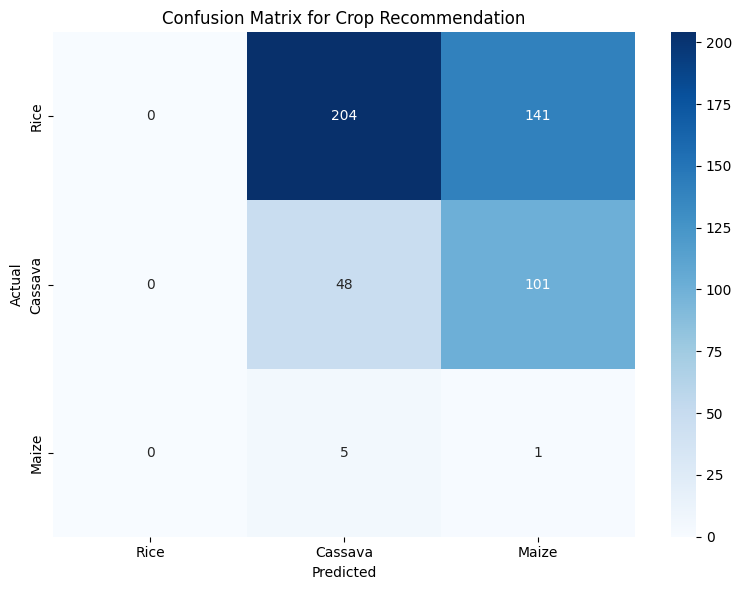

🌍 AVAILABLE COUNTRIES:
MWI: Malawi

📍 AVAILABLE REGIONS (showing first 15):
MWI.1.1_1: Northern Region - Chitipa
MWI.1.2_1: Northern Region - Karonga
MWI.1.3_1: Northern Region - Rumphi
MWI.2.1_1: Central Region - Kasungu
MWI.2.2_1: Central Region - Nkhotakota
MWI.2.3_1: Central Region - Ntchisi
MWI.2.4_1: Central Region - Dowa
MWI.2.5_1: Central Region - Salima
MWI.2.6_1: Central Region - Lilongwe
MWI.2.7_1: Central Region - Mchinji
MWI.2.8_1: Region MWI.2.8_1
MWI.2.9_1: Region MWI.2.9_1
MWI.3.1_1: Southern Region - Mangochi
MWI.3.2_1: Southern Region - Machinga
MWI.3.3_1: Southern Region - Zomba
... and 223 more regions

💡 Tip: Type 'Malawi' for country-level forecast or a GID code for regional analysis

✅ Prepared country-level data for Malawi
   Time range: 2022-01-01 00:00:00 to 2025-02-18 00:00:00
   Total records: 73

Choose forecasting method:
1. Fast/Simple
2. Accurate/Slow (Prophet)
3. SARIMAX (Seasonal ARIMA)

🔮 Forecasting for Malawi (5 years)...
Using fast simple forecasti

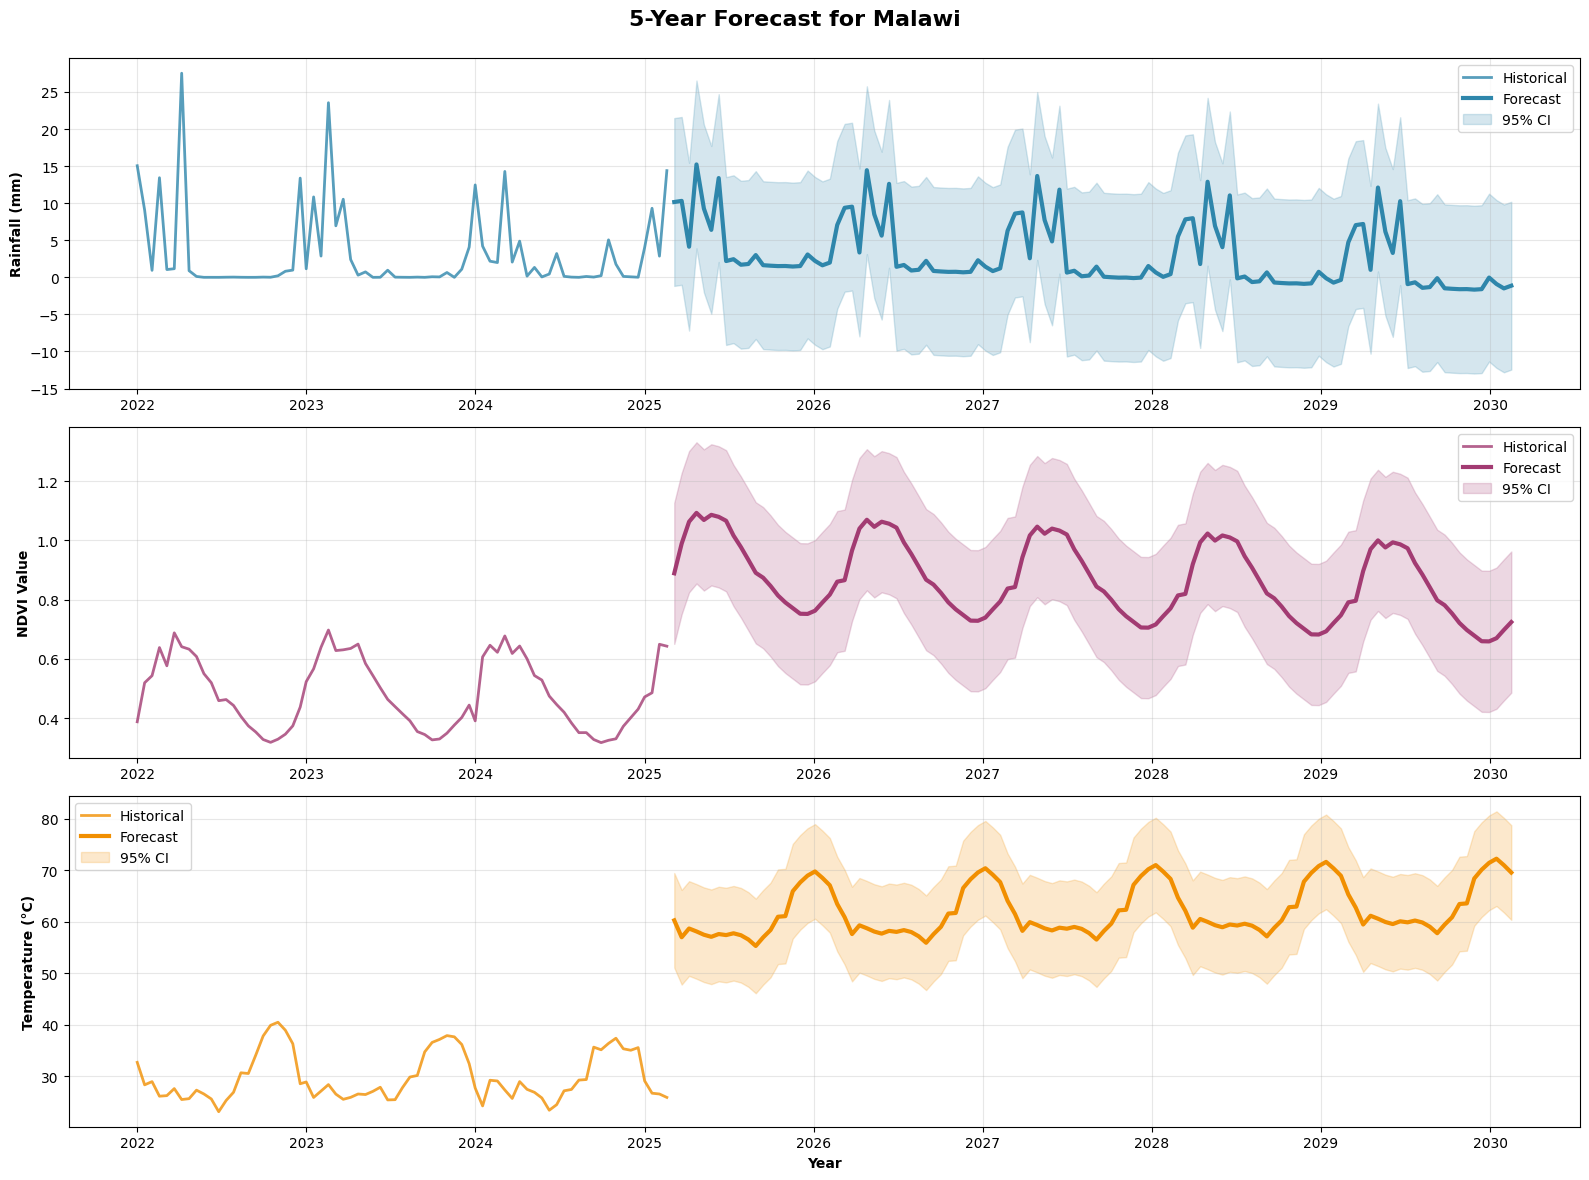


📊 FORECAST SUMMARY: Malawi

📅 Forecast Period: 2025-03-06 to 2030-02-16

🌧  Rainfall Forecast:
   Average: 3.0 mm
   Range: -1.7 - 15.2 mm

🌿 Vegetation Health (NDVI):
   Average: 0.867
   Range: 0.659 - 1.093

🌡  Temperature Forecast:
   Average: 62.0°C
   Range: 55.3 - 72.3°C

🌾 CROP RECOMMENDATION FOR Malawi
Based on the average forecasted conditions:
  🌾 Recommended Crop: Cassava
  🧠 Reason: High temperature and high NDVI are ideal for Cassava.

💾 Forecast saved to: forecast_malawi.csv

Thank you for using the Climate Forecasting System! 👋


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
warnings.filterwarnings('ignore')

# Add for new models
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# --- Crop Recommendation Logic ---
def recommend_crop(avg_temp, avg_ndvi):
    """
    Recommends a crop (Rice, Cassava, Maize) based on average forecasted
    Temperature (LST) and NDVI.
    """
    high_temp_threshold = 29.0
    moderate_temp_upper = 31.0
    moderate_ndvi_threshold = 0.55
    recommendation = "Unclassified"

    if avg_temp > high_temp_threshold:
        if avg_ndvi > moderate_ndvi_threshold:
            recommendation = "Cassava"
            reason = "High temperature and high NDVI are ideal for Cassava."
        else:
            recommendation = "Cassava"
            reason = "High temperature; Cassava is the most drought-tolerant option."
    else:
        if avg_ndvi > moderate_ndvi_threshold:
            if high_temp_threshold < avg_temp <= moderate_temp_upper:
                recommendation = "Rice"
                reason = "Moderate temperature with high NDVI suggests good water availability, suitable for Rice."
            else:
                if avg_temp <= high_temp_threshold:
                    recommendation = "Maize"
                    reason = "Moderate/lower temperature with high NDVI, suitable for Maize."
                else:
                    recommendation = "Rice"
                    reason = "Conditions support high vegetation health, suitable for Rice."
        else:
            if avg_temp > high_temp_threshold - 1.5:
                recommendation = "Cassava"
                reason = "Warmer conditions, even with moderate NDVI, favor drought-tolerant Cassava."
            else:
                recommendation = "Maize"
                reason = "Moderate/lower temperature with moderate/low NDVI suits Maize."

    if recommendation == "Unclassified":
        if avg_temp > high_temp_threshold:
            recommendation = "Cassava"
            reason = "Defaulting to Cassava for high temperature."
        elif avg_ndvi > moderate_ndvi_threshold:
            recommendation = "Rice"
            reason = "Defaulting to Rice for high NDVI with non-extreme temp."
        else:
            recommendation = "Maize"
            reason = "Defaulting to Maize for other conditions."

    return recommendation, reason

# --- Optimized Data Loading ---
def load_data_optimized():
    """
    Load and parse CSV data using pandas for better performance
    """
    try:
        # Use pandas to read CSV directly - much faster than regex parsing
        combined_df = pd.read_csv('combined_with_plants.csv')
        
        # Convert DATE column to datetime
        combined_df['DATE'] = pd.to_datetime(combined_df['DATE'], format='%m/%d/%Y', errors='coerce')
        
        # Drop rows with invalid dates or missing critical data
        combined_df = combined_df.dropna(subset=['DATE', 'RAINFALL_MM', 'NDVI_VALUE', 'LST_VALUE'])
        
        # Ensure numeric columns are properly typed
        numeric_cols = ['RAINFALL_MM', 'NDVI_VALUE', 'LST_VALUE']
        for col in numeric_cols:
            combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')
        
        combined_df = combined_df.dropna(subset=numeric_cols)
        combined_df = combined_df.reset_index(drop=True)
        
        print(f"✅ Data loaded successfully. Total records: {len(combined_df)}")
        return combined_df
        
    except FileNotFoundError:
        print("❌ Error: File 'combined_with_plants.csv' not found.")
        return None
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

# --- Model Evaluation ---
def evaluate_crop_recommendation(combined_df, sample_size=1000):
    """
    Evaluate the crop recommendation model using a sample of historical data
    """
    print("\n" + "=" * 60)
    print("📈 MODEL EVALUATION")
    print("=" * 60)

    # Use a sample for faster evaluation if dataset is large
    if len(combined_df) > sample_size:
        sample_df = combined_df.sample(n=sample_size, random_state=42)
        print(f"Using sample of {sample_size} records for evaluation")
    else:
        sample_df = combined_df

    # Apply recommendation logic to historical data
    predictions = []
    actuals = sample_df['RECOMMENDED'].tolist()

    for _, row in sample_df.iterrows():
        pred, _ = recommend_crop(row['LST_VALUE'], row['NDVI_VALUE'])
        predictions.append(pred)

    # Calculate metrics
    accuracy = accuracy_score(actuals, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        actuals, predictions, average='weighted', zero_division=0
    )

    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision (Weighted): {precision:.3f}")
    print(f"Recall (Weighted): {recall:.3f}")
    print(f"F1-Score (Weighted): {f1:.3f}")

    # Confusion Matrix
    unique_labels = list(set(actuals + predictions))
    cm = confusion_matrix(actuals, predictions, labels=unique_labels)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=unique_labels, yticklabels=unique_labels)
    plt.title('Confusion Matrix for Crop Recommendation')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# --- Forecasting System ---
def create_region_mapping(combined_df):
    """
    Create a mapping of GID_2 codes to human-readable region names
    """
    unique_gids = combined_df['GID_2'].unique()
    malawi_regions = {
        'MWI.1.1_1': 'Northern Region - Chitipa',
        'MWI.1.2_1': 'Northern Region - Karonga',
        'MWI.1.3_1': 'Northern Region - Rumphi',
        'MWI.2.1_1': 'Central Region - Kasungu',
        'MWI.2.2_1': 'Central Region - Nkhotakota',
        'MWI.2.3_1': 'Central Region - Ntchisi',
        'MWI.2.4_1': 'Central Region - Dowa',
        'MWI.2.5_1': 'Central Region - Salima',
        'MWI.2.6_1': 'Central Region - Lilongwe',
        'MWI.2.7_1': 'Central Region - Mchinji',
        'MWI.3.1_1': 'Southern Region - Mangochi',
        'MWI.3.2_1': 'Southern Region - Machinga',
        'MWI.3.3_1': 'Southern Region - Zomba',
        'MWI.3.4_1': 'Southern Region - Chiradzulu',
        'MWI.3.5_1': 'Southern Region - Blantyre',
        'MWI.3.6_1': 'Southern Region - Mwanza',
        'MWI.3.7_1': 'Southern Region - Thyolo',
        'MWI.3.8_1': 'Southern Region - Mulanje',
        'MWI.3.9_1': 'Southern Region - Phalombe',
        'MWI.4.1_1': 'Southern Region - Chikwawa',
        'MWI.4.2_1': 'Southern Region - Nsanje',
        'MWI.4.3_1': 'Southern Region - Balaka',
        'MWI.4.4_1': 'Southern Region - Neno',
    }
    region_mapping = {gid: malawi_regions.get(gid, f"Region {gid}") for gid in unique_gids}
    return region_mapping

def get_available_options(combined_df):
    """
    Get available countries and regions for user selection
    """
    combined_df['country_code'] = combined_df['GID_2'].str.slice(0, 3)
    country_mapping = {
        'MWI': 'Malawi',
        'GHA': 'Ghana',
        'UGA': 'Uganda',
        'SEN': 'Senegal',
        'BEN': 'Benin'
    }
    available_countries = {code: country_mapping.get(code, f"Country_{code}") 
                         for code in combined_df['country_code'].unique()}
    return available_countries, create_region_mapping(combined_df)

def display_available_options(available_countries, region_mapping):
    """
    Display available options to the user
    """
    print("🌍 AVAILABLE COUNTRIES:")
    print("=" * 40)
    for code, name in available_countries.items():
        print(f"{code}: {name}")
    
    print("\n📍 AVAILABLE REGIONS (showing first 15):")
    print("=" * 60)
    region_items = list(region_mapping.items())
    for gid, name in region_items[:15]:
        print(f"{gid}: {name}")
    if len(region_mapping) > 15:
        print(f"... and {len(region_mapping) - 15} more regions")
    print(f"\n💡 Tip: Type 'Malawi' for country-level forecast or a GID code for regional analysis")

def get_user_selection(available_countries, region_mapping):
    """
    Get user input for country/region selection
    """
    while True:
        print("\n" + "=" * 60)
        user_input = input("Enter country name (e.g., 'Malawi') or GID code (e.g., 'MWI.1.1_1'): ").strip()
        
        # Check for country match
        country_lower = user_input.lower()
        for code, name in available_countries.items():
            if country_lower == name.lower():
                return {'type': 'country', 'value': code, 'name': name}
        
        # Check for region match
        if user_input in region_mapping:
            return {'type': 'region', 'value': user_input, 'name': region_mapping[user_input]}
        
        # Special case for Malawi
        if country_lower == 'malawi':
            return {'type': 'country', 'value': 'MWI', 'name': 'Malawi'}
        
        print("❌ Invalid selection. Please choose from the available options.")
        display_available_options(available_countries, region_mapping)

def prepare_data_for_forecast(combined_df, selection):
    """
    Prepare data based on user selection with optimized aggregation
    """
    if selection['type'] == 'country':
        country_code = selection['value']
        # Use vectorized operations for filtering
        mask = combined_df['GID_2'].str.startswith(country_code)
        country_data = combined_df[mask]
        
        if country_data.empty:
            print(f"❌ No data found for country code: {country_code}")
            return None
        
        # Optimized aggregation
        aggregated_data = (country_data.groupby('DATE')
                         .agg({'RAINFALL_MM': 'mean', 'NDVI_VALUE': 'mean', 'LST_VALUE': 'mean'})
                         .sort_index())
        
        print(f"✅ Prepared country-level data for {selection['name']}")
        print(f"   Time range: {aggregated_data.index.min()} to {aggregated_data.index.max()}")
        print(f"   Total records: {len(aggregated_data)}")
        return aggregated_data
    else:
        region_gid = selection['value']
        # Use boolean indexing for better performance
        mask = combined_df['GID_2'] == region_gid
        region_data = combined_df[mask].sort_values('DATE')
        
        if region_data.empty:
            print(f"❌ No data found for region: {region_gid}")
            return None
        
        region_data = region_data.set_index('DATE')[['RAINFALL_MM', 'NDVI_VALUE', 'LST_VALUE']]
        print(f"✅ Prepared region-level data for {selection['name']}")
        print(f"   Time range: {region_data.index.min()} to {region_data.index.max()}")
        print(f"   Total records: {len(region_data)}")
        return region_data

def simple_forecast(series, periods=115):
    """
    Simple forecasting method using linear trend + seasonality
    Much faster than Prophet for quick results
    """
    # Extract trend using simple linear regression
    x = np.arange(len(series))
    trend = np.polyfit(x, series.values, 1)
    
    # Calculate seasonal component (assume yearly cycle)
    seasonal_period = min(23, len(series) // 2)  # 23 periods ≈ 1 year for 16-day data
    if seasonal_period > 1:
        seasonal = []
        for i in range(seasonal_period):
            seasonal.append(np.mean([series.iloc[j] for j in range(i, len(series), seasonal_period)]))
        seasonal = np.array(seasonal)
    else:
        seasonal = np.array([0])
    
    # Generate forecast
    last_date = series.index[-1]
    future_dates = pd.date_range(last_date + pd.Timedelta(days=16), periods=periods, freq='16D')
    
    forecast_values = []
    for i in range(periods):
        trend_value = trend[0] * (len(series) + i) + trend[1]
        seasonal_value = seasonal[i % len(seasonal)] if len(seasonal) > 1 else 0
        forecast_values.append(trend_value + seasonal_value)
    
    forecast_series = pd.Series(forecast_values, index=future_dates)
    
    # Simple confidence intervals (±10% of forecast value)
    std_dev = series.std()
    lower = forecast_series - 2 * std_dev
    upper = forecast_series + 2 * std_dev
    
    return forecast_series, lower, upper

def prophet_forecast(series, periods=115, yearly_seasonality=True):
    """
    Use Facebook's Prophet for robust forecasting (optional, slower)
    """
    try:
        from prophet import Prophet
        
        prophet_df = pd.DataFrame({
            'ds': series.index,
            'y': series.values
        })
        
        # Suppress Prophet logging
        import logging
        logging.getLogger('prophet').setLevel(logging.WARNING)
        
        model = Prophet(
            yearly_seasonality=yearly_seasonality,
            weekly_seasonality=False,
            daily_seasonality=False,
            changepoint_prior_scale=0.05
        )
        model.fit(prophet_df)
        
        future = model.make_future_dataframe(periods=periods, freq='16D')
        forecast = model.predict(future)
        
        forecast_series = forecast.set_index('ds')['yhat'][-periods:]
        confidence_lower = forecast.set_index('ds')['yhat_lower'][-periods:]
        confidence_upper = forecast.set_index('ds')['yhat_upper'][-periods:]
        
        return forecast_series, confidence_lower, confidence_upper
        
    except ImportError:
        print("⚠ Prophet not available, using simple forecasting method")
        return simple_forecast(series, periods)

def sarimax_forecast(series, periods=115):
    """
    SARIMAX forecasting implementation
    """
    try:
        # Handle missing values
        series = series.dropna()
        
        if len(series) < 24:  # Need at least 2 years of data (assuming 16-day intervals)
            print("⚠ Insufficient data for SARIMAX, using simple forecasting")
            return simple_forecast(series, periods)
        
        # Automatically determine seasonal period (assuming 16-day intervals)
        # For 16-day data, seasonal period is approximately 23 (365/16 ≈ 23)
        seasonal_period = 23
        
        # SARIMAX model with seasonal components
        # Order: (p,d,q) - ARIMA parameters
        # Seasonal_order: (P,D,Q,s) - Seasonal parameters
        model = SARIMAX(
            series,
            order=(1, 1, 1),           # Non-seasonal ARIMA(1,1,1)
            seasonal_order=(1, 1, 1, seasonal_period),  # Seasonal SARIMA(1,1,1,23)
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        # Fit the model
        fitted_model = model.fit(disp=False)
        
        # Forecast
        forecast_result = fitted_model.get_forecast(steps=periods)
        forecast_mean = forecast_result.predicted_mean
        forecast_ci = forecast_result.conf_int()
        
        # Create forecast series with proper dates
        last_date = series.index[-1]
        future_dates = pd.date_range(last_date + pd.Timedelta(days=16), periods=periods, freq='16D')
        
        forecast_series = pd.Series(forecast_mean.values, index=future_dates)
        lower_bound = pd.Series(forecast_ci.iloc[:, 0].values, index=future_dates)
        upper_bound = pd.Series(forecast_ci.iloc[:, 1].values, index=future_dates)
        
        return forecast_series, lower_bound, upper_bound
        
    except Exception as e:
        print(f"⚠ SARIMAX failed: {e}, using simple forecasting method")
        return simple_forecast(series, periods)

def run_forecast(data, selection, forecast_years=5, use_simple=True, use_sarimax=False):
    """
    Run the forecasting pipeline with option for simple, SARIMAX, or advanced forecasting
    """
    periods = int(365 * forecast_years / 16)
    if periods <= 0:
        periods = 60
    
    print(f"\n🔮 Forecasting for {selection['name']} ({forecast_years} years)...")
    
    if use_sarimax:
        print("Using SARIMAX forecasting...")
        rainfall_forecast, rain_lower, rain_upper = sarimax_forecast(data['RAINFALL_MM'], periods)
        ndvi_forecast, ndvi_lower, ndvi_upper = sarimax_forecast(data['NDVI_VALUE'], periods)
        lst_forecast, lst_lower, lst_upper = sarimax_forecast(data['LST_VALUE'], periods)
    elif use_simple:
        print("Using fast simple forecasting method...")
        rainfall_forecast, rain_lower, rain_upper = simple_forecast(data['RAINFALL_MM'], periods)
        ndvi_forecast, ndvi_lower, ndvi_upper = simple_forecast(data['NDVI_VALUE'], periods)
        lst_forecast, lst_lower, lst_upper = simple_forecast(data['LST_VALUE'], periods)
    else:
        print("Using Prophet forecasting (slower but more accurate)...")
        rainfall_forecast, rain_lower, rain_upper = prophet_forecast(data['RAINFALL_MM'], periods)
        ndvi_forecast, ndvi_lower, ndvi_upper = prophet_forecast(data['NDVI_VALUE'], periods)
        lst_forecast, lst_lower, lst_upper = prophet_forecast(data['LST_VALUE'], periods)
    
    forecasts = pd.DataFrame({
        'RAINFALL_MM': rainfall_forecast.values,
        'NDVI_VALUE': ndvi_forecast.values,
        'LST_VALUE': lst_forecast.values
    }, index=rainfall_forecast.index)
    
    confidence_intervals = {
        'rainfall': {'lower': rain_lower, 'upper': rain_upper},
        'ndvi': {'lower': ndvi_lower, 'upper': ndvi_upper},
        'lst': {'lower': lst_lower, 'upper': lst_upper}
    }
    
    return forecasts, confidence_intervals

def plot_results(historical_data, forecasts, ci_dict, selection):
    """
    Plot forecasting results with optimized plotting
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12))
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    # Rainfall plot
    ax1.plot(historical_data.index, historical_data['RAINFALL_MM'],
             label='Historical', linewidth=2, color=colors[0], alpha=0.8)
    ax1.plot(forecasts.index, forecasts['RAINFALL_MM'],
             label='Forecast', linewidth=3, color=colors[0])
    ax1.fill_between(forecasts.index, ci_dict['rainfall']['lower'], ci_dict['rainfall']['upper'],
                    color=colors[0], alpha=0.2, label='95% CI')
    ax1.set_ylabel('Rainfall (mm)', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # NDVI plot
    ax2.plot(historical_data.index, historical_data['NDVI_VALUE'],
             label='Historical', linewidth=2, color=colors[1], alpha=0.8)
    ax2.plot(forecasts.index, forecasts['NDVI_VALUE'],
             label='Forecast', linewidth=3, color=colors[1])
    ax2.fill_between(forecasts.index, ci_dict['ndvi']['lower'], ci_dict['ndvi']['upper'],
                    color=colors[1], alpha=0.2, label='95% CI')
    ax2.set_ylabel('NDVI Value', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Temperature plot
    ax3.plot(historical_data.index, historical_data['LST_VALUE'],
             label='Historical', linewidth=2, color=colors[2], alpha=0.8)
    ax3.plot(forecasts.index, forecasts['LST_VALUE'],
             label='Forecast', linewidth=3, color=colors[2])
    ax3.fill_between(forecasts.index, ci_dict['lst']['lower'], ci_dict['lst']['upper'],
                    color=colors[2], alpha=0.2, label='95% CI')
    ax3.set_ylabel('Temperature (°C)', fontweight='bold')
    ax3.set_xlabel('Year', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.suptitle(f'5-Year Forecast for {selection["name"]}\n', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def generate_summary(forecasts, selection):
    """
    Generate forecast summary and crop recommendation
    """
    print("\n" + "=" * 60)
    print(f"📊 FORECAST SUMMARY: {selection['name']}")
    print("=" * 60)
    
    avg_rainfall = forecasts['RAINFALL_MM'].mean()
    avg_ndvi = forecasts['NDVI_VALUE'].mean()
    avg_temp = forecasts['LST_VALUE'].mean()
    
    print(f"\n📅 Forecast Period: {forecasts.index[0].strftime('%Y-%m-%d')} to {forecasts.index[-1].strftime('%Y-%m-%d')}")
    print(f"\n🌧  Rainfall Forecast:")
    print(f"   Average: {avg_rainfall:.1f} mm")
    print(f"   Range: {forecasts['RAINFALL_MM'].min():.1f} - {forecasts['RAINFALL_MM'].max():.1f} mm")
    
    print(f"\n🌿 Vegetation Health (NDVI):")
    print(f"   Average: {avg_ndvi:.3f}")
    print(f"   Range: {forecasts['NDVI_VALUE'].min():.3f} - {forecasts['NDVI_VALUE'].max():.3f}")
    
    print(f"\n🌡  Temperature Forecast:")
    print(f"   Average: {avg_temp:.1f}°C")
    print(f"   Range: {forecasts['LST_VALUE'].min():.1f} - {forecasts['LST_VALUE'].max():.1f}°C")
    
    print("\n" + "=" * 60)
    print(f"🌾 CROP RECOMMENDATION FOR {selection['name']}")
    print("=" * 60)
    
    recommended_crop, reason = recommend_crop(avg_temp, avg_ndvi)
    print(f"Based on the average forecasted conditions:")
    print(f"  🌾 Recommended Crop: {recommended_crop}")
    print(f"  🧠 Reason: {reason}")
    print("=" * 60)

def main():
    """
    Main interactive forecasting system - optimized version
    """
    print("🌍 WELCOME TO THE CLIMATE FORECASTING SYSTEM")
    print("=" * 50)
    print("This system predicts Rainfall, Vegetation Health, and Temperature")
    print("for any available country or region for the next 5 years!")
    print("It also provides a crop recommendation (Rice, Cassava, Maize)!")
    print("=" * 50)
    
    # Load data using optimized method
    combined_df = load_data_optimized()
    if combined_df is None:
        return
    
    # Quick model evaluation with smaller sample
    print("\n⚡ Running quick model evaluation...")
    evaluate_crop_recommendation(combined_df, sample_size=500)
    
    # Get available options
    available_countries, region_mapping = get_available_options(combined_df)
    
    while True:
        display_available_options(available_countries, region_mapping)
        selection = get_user_selection(available_countries, region_mapping)
        
        data = prepare_data_for_forecast(combined_df, selection)
        if data is None or data.empty:
            print("⚠ Unable to prepare data for forecasting. Please try another selection.")
            continue
        
        # Ask user about forecasting method
        print("\nChoose forecasting method:")
        print("1. Fast/Simple")
        print("2. Accurate/Slow (Prophet)")
        print("3. SARIMAX (Seasonal ARIMA)")
        method_choice = input("Enter choice (1/2/3): ").strip()
        
        use_simple = method_choice == '1'
        use_sarimax = method_choice == '3'
        
        try:
            forecasts, ci_dict = run_forecast(data, selection, use_simple=use_simple, use_sarimax=use_sarimax)
        except Exception as e:
            print(f"❌ Error during forecasting: {e}")
            continue
        
        try:
            plot_results(data, forecasts, ci_dict, selection)
        except Exception as e:
            print(f"⚠ Could not display plot: {e}")
        
        generate_summary(forecasts, selection)
        
        # Save results
        filename = f"forecast_{selection['name'].replace(' ', '_').lower()}.csv"
        try:
            forecasts.to_csv(filename)
            print(f"\n💾 Forecast saved to: {filename}")
        except Exception as e:
            print(f"⚠ Could not save forecast to file: {e}")
        
        print("\n" + "=" * 50)
        continue_choice = input("Would you like to forecast another region? (yes/no): ").strip().lower()
        if continue_choice not in ['yes', 'y']:
            print("Thank you for using the Climate Forecasting System! 👋")
            break

if __name__ == "__main__":
    main()